[*********************100%***********************]  1 of 1 completed


                  Close      RV20        IV
Date                                       
2015-02-02  8797.400391  0.185042  0.185042
2015-02-03  8756.549805  0.186102  0.186102
2015-02-04  8723.700195  0.144481  0.144481
2015-02-05  8711.700195  0.143545  0.143545
2015-02-06  8661.049805  0.139068  0.139068
Loaded Close + IV.


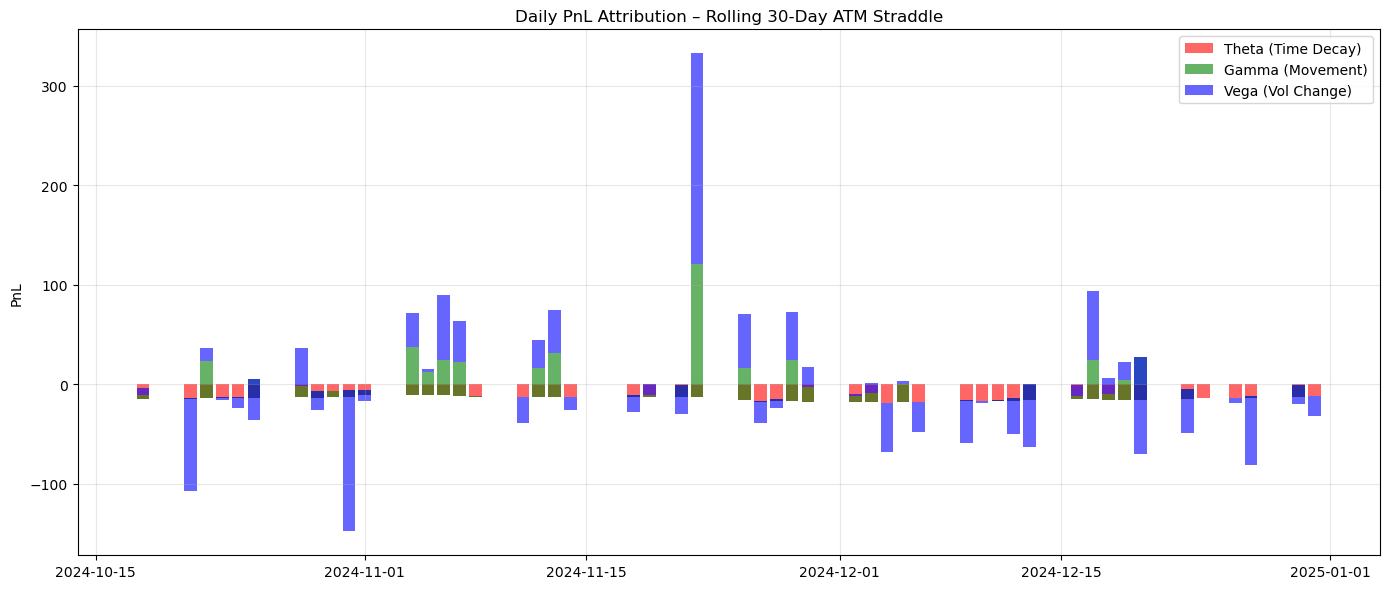


PnL Attribution Summary
Total Theta : -21021.18
Total Gamma : 23675.39
Total Vega  : -352.51
Total PnL: 2301.70


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

ticker = "^NSEI"      
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

df = pd.DataFrame()
df['Close'] = data['Close']

returns = df['Close'].pct_change()
df['RV20'] = returns.rolling(20).std() * np.sqrt(252)
df['IV'] = df['RV20']

df = df.dropna()
print(df.head())
print("Loaded Close + IV.")

def atm_straddle(S, sigma, T, r=0.04):

    d1 = 0.5 * sigma * np.sqrt(T)
    pdf = norm.pdf(d1)

    gamma_single = pdf / (S * sigma * np.sqrt(T))
    vega_single = S * pdf * np.sqrt(T)
    theta_single = -(S * pdf * sigma) / (2 * np.sqrt(T))

    gamma = 2 * gamma_single
    vega  = 2 * vega_single
    theta = 2 * theta_single

    return gamma, vega, theta

def greeks(df, T_days=30, r=0.04):
    T = T_days / 252

    greek_vals = df.apply(lambda row: atm_straddle(row['Close'], row['IV'], T, r), axis=1)

    df[['Gamma', 'Vega', 'Theta']] = pd.DataFrame(greek_vals.tolist(), index=df.index)
    return df

df = greeks(df)

def pnl(df):
    df['dS'] = df['Close'].diff()
    df['dVol'] = df['IV'].diff()
    dt = 1/252

    gamma = df['Gamma'].shift(1)
    vega  = df['Vega'].shift(1)
    theta = df['Theta'].shift(1)

    df['pnl_gamma'] = 0.5 * gamma * (df['dS'] ** 2)
    df['pnl_vega']  = vega * df['dVol']
    df['pnl_theta'] = theta * dt

    df['pnl_total'] = df['pnl_gamma'] + df['pnl_vega'] + df['pnl_theta']
    return df

df = pnl(df)

def plot_pnl(df, days=50):
    subset = df.tail(days)

    plt.figure(figsize=(14, 6))
    plt.bar(subset.index, subset['pnl_theta'], label='Theta (Time Decay)', color='red', alpha=0.6)
    plt.bar(subset.index, subset['pnl_gamma'],
            bottom=subset['pnl_theta'], label='Gamma (Movement)', color='green', alpha=0.6)
    plt.bar(subset.index, subset['pnl_vega'],
            bottom=subset['pnl_theta'] + subset['pnl_gamma'],
            label='Vega (Vol Change)', color='blue', alpha=0.6)

    plt.title('Daily PnL Attribution – Rolling 30-Day ATM Straddle')
    plt.ylabel('PnL')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('PnL.png')
    plt.show()
    

plot_pnl(df, days=50)

def summary(df):
    print("\nPnL Attribution Summary")
    print(f"Total Theta : {df['pnl_theta'].sum():.2f}")
    print(f"Total Gamma : {df['pnl_gamma'].sum():.2f}")
    print(f"Total Vega  : {df['pnl_vega'].sum():.2f}")
    print(f"Total PnL: {df['pnl_total'].sum():.2f}")

summary(df)
